In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import io
import cvxpy as cp
import statsmodels.api as sm
import datetime as dt
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
import time
from numpy import diag, sqrt, log, trace
from numpy.linalg import inv

Symbols,MSFT,IBM,AAPL,GOOG
Date,,,,
2021-05-19,4.162759,1.050937,4.548510,2.936767
2021-05-20,4.220290,1.056001,4.644084,2.997036
2021-05-21,4.197860,1.062313,4.575504,2.983057
2021-05-24,4.293916,1.062166,4.636423,3.061376
2021-05-25,4.310011,1.055341,4.629128,3.064429


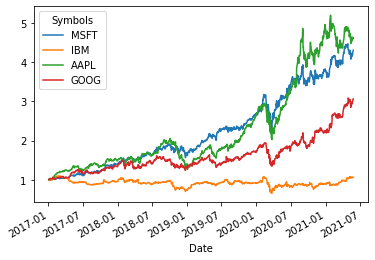

In [2]:
# load data 
stocks = DataReader(['MSFT', 'IBM', 'AAPL', 'GOOG'], 'yahoo', start=dt.datetime(2017,1,1),end=dt.datetime(2021,5,25))['Adj Close']
# plot normalized prices of these stocks
normalized_price = stocks / stocks.iloc[0,:]
normalized_price.plot()
normalized_price.tail()
# data.shape
# stocks.plot()

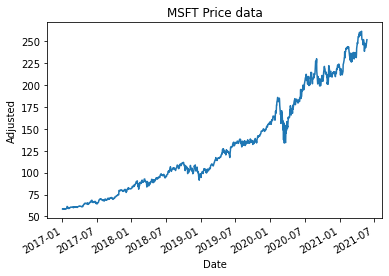

In [3]:
stocks['MSFT'].plot()
plt.xlabel("Date")
plt.ylabel("Adjusted")
plt.title("MSFT Price data")
plt.show()

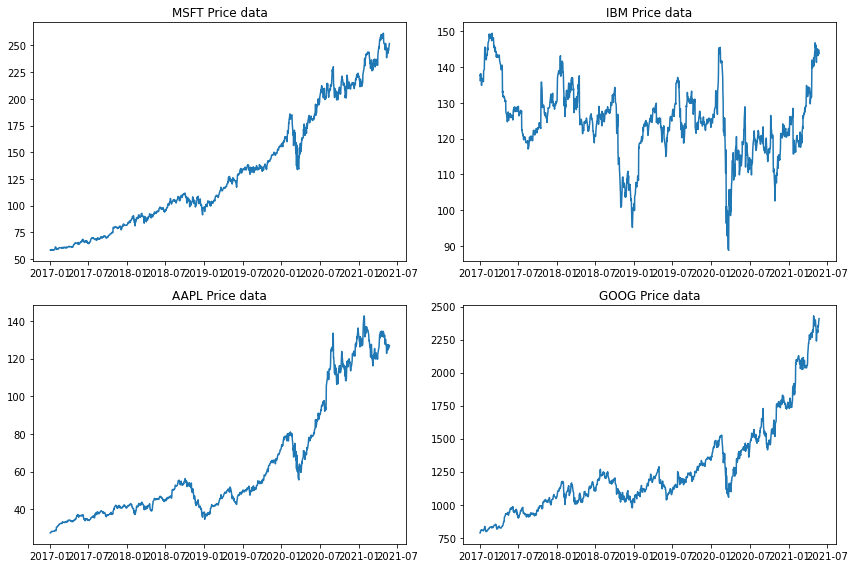

In [4]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.plot(stocks['MSFT'])
ax1.set_title("MSFT Price data")
ax2.plot(stocks['IBM'])
ax2.set_title("IBM Price data")
ax3.plot(stocks['AAPL'])
ax3.set_title("AAPL Price data")
ax4.plot(stocks['GOOG'])
ax4.set_title("GOOG Price data")
plt.tight_layout()
plt.show()

In [5]:
MSFT_daily_returns = stocks['MSFT'].pct_change().sum()
MSFT_monthly_returns = stocks['MSFT'].resample('M').ffill().pct_change()
print(MSFT_daily_returns)

1.6397253213106309


In [6]:
stocks.describe()

Symbols,MSFT,IBM,AAPL,GOOG
count,1106.000000,1106.000000,1106.000000,1106.000000
mean,131.704419,124.884073,63.349726,1260.381748
std,57.005517,10.005240,31.966140,349.785041
min,58.142242,88.795891,27.382690,786.140015
25%,86.622334,119.756485,40.623611,1039.482483
50%,113.403908,124.833046,49.595364,1164.280029
75%,177.502026,130.000252,78.222795,1416.349976
max,261.366486,149.450806,142.704010,2429.889893


In [7]:
data = stocks/stocks.shift(1) # pt/pt-1
data = data.dropna(how='all') # delete 'NaN'
x = data.to_numpy() # relative price
#data.info()
N=x.shape[0]
d=x.shape[1]
# x=np.zeros((N,d))
b=np.ones(d)/d
x

array([[0.99552552, 1.01238108, 0.99888078, 1.00096676],
       [1.        , 0.99669153, 1.00508546, 1.00904816],
       [1.00866783, 1.00491991, 1.01114819, 1.0152767 ],
       ...,
       [0.99468518, 1.00597721, 0.98523292, 0.9953355 ],
       [1.02288208, 0.99986179, 1.01331418, 1.02625467],
       [1.00374832, 0.99357374, 0.99842646, 1.00099729]])

In [8]:
BAH = np.dot(np.prod(data.to_numpy(), axis=0), np.ones(d)/d)

In [9]:
def opt_fractions(r):
    x = cp.Variable(d)
    constraints=[x>=0,cp.sum(x)==1]
    obj=cp.sum(cp.log(r@x))
    problem=cp.Problem(cp.Maximize(obj),constraints)
    problem.solve()
    return x.value

In [10]:
BCRP = np.prod(x@opt_fractions(x))

In [11]:
def simplex_proj(y):
    """ Projection of y onto simplex. """
    m = len(y)
    bget = False
    s = sorted(y, reverse=True)
    tmpsum = 0.
    for ii in range(m-1):
        tmpsum = tmpsum + s[ii]
        tmax = (tmpsum - 1) / (ii + 1);
        if tmax >= s[ii+1]:
            bget = True
            break
    if not bget:
        tmax = (tmpsum + s[m-1] -1)/m

    return np.maximum(y-tmax,0.)

In [12]:
def CWMR_Var(x, x_bar, mu, sigma, M, V, theta, eps):
    # lambda from equation 7
    a = 2 * phi * V**2 - 2 * phi * x_bar * V * W
    b = 2 * phi * eps * V - 2 * phi * V * M + V - x_bar * W
    c = eps - M - phi * V
    t1 = b
    t2 = sqrt(b**2 - 4 * a * c)
    t3 = 2 * a
    if((a!=0)&(np.isreal(t2))&(t2>0)):
        gamma1 = (-t1+t2)/t3 
        gamma2 = (-t1-t2)/t3
        lambd = np.maximum(np.maximum(gamma1,gamma2),0)
    elif(a == 0) & (b != 0):
        gamma3 = -c/b
        lambd = np.maximum(gamma3,0)   
    else:
        lambd = 0
    mu = mu - lambd * np.dot(sigma,(x - x_bar))/ M
    sigma = inv(inv(sigma) + 2 * lambd * phi * diag(x)**2)
    return mu, sigma

def CWMR_Stdev(x, x_bar, mu, sigma, M, V, theta, eps):
    # lambda from equation 7
    a = (V - x_bar * W + phi**2 * V / 2)**2 - (phi**4) * (V**2) / 4
    b = 2 * (eps - M) * (V - x_bar * W + (phi**2) * V / 2)
    c = (eps - M)**2 - (phi**2) * V
    t1 = b
    t2 = sqrt(b**2 - 4 * a * c)
    t3 = 2 * a
    if((a!=0)&(np.isreal(t2))&(t2>0)):
        gamma1 = (-t1+t2)/t3 
        gamma2 = (-t1-t2)/t3
        lambd = np.maximum(np.maximum(gamma1,gamma2),0)
    elif(a == 0) & (b != 0):
        gamma3 = -c/b
        lambd = np.maximum(gamma3,0)   
    else:
        lambd = 0
    mu = mu - lambd * np.dot(sigma,(x - x_bar))/ M
    sigma = inv(inv(sigma) + 2 * lambd * phi * diag(x)**2)
    return mu, sigma

In [13]:
start = time.time()
# INPUT:
phi=0.95 # Confidence parameter for profitable mean reversion portfolio.Recommended value is 0.95.
eps=-0.5 # Mean reversion threshold (expected return on current day must be lower than this threshold). Recommended value is -0.5.
# INITIALIZE:
cum_ret=1
lambd = 0
mu = np.ones(d)/d # mu: last portfolio mean
sigma = np.eye(d)/(d**2) # sigma: last diagonal covariance matrix
weight=mu/np.sum(mu)
theta = scipy.stats.norm.ppf(phi) # Quantile function (inverse of CDF
daily_r=np.ones(N)

for t in range(N-1):
    # 4. Calculate the following variables    
    M = np.dot(mu.T,x[t])
    V = np.dot(np.dot(x[t].T, sigma),x[t])
    W = np.dot(np.dot(x[t].T, sigma),np.ones(d))
    x_bar = (np.dot(np.ones(d),np.dot(sigma,x[t]))/np.dot((np.dot(np.ones(d),sigma)),np.ones(d)))
    # 5. Update mu and sigma
#     mu, sigma = CWMR_Var(x[t], x_bar, mu, sigma, M, V, theta, eps)
    mu, sigma = CWMR_Stdev(x[t], x_bar, mu, sigma, M, V, theta, eps)
    # 6. Normalize mu and sigma    
    mu = simplex_proj(mu)
    sigma = sigma / (d**2 * trace(sigma))
    weight = mu
#     tc = gamma/2 * (np.abs(((x[t+1]*weight)/ (np.dot(x[t+1],weight)))[1:] - weight[1:])).sum()
    daily_r[t] = np.dot(x[t+1],weight) #* (1-tc)
    cum_ret = cum_ret * daily_r[t] 
print("Cumulative return:",cum_ret,"-----> Expressed by scientific counting:",f'{cum_ret:1.2e}') 

end = time.time()
print("Program running time:",end-start)

Cumulative return: 2.171058868610402 -----> Expressed by scientific counting: 2.17e+00
Program running time: 0.28597164154052734


Text(0.5, 1.0, 'Daily return Portfolio Value')

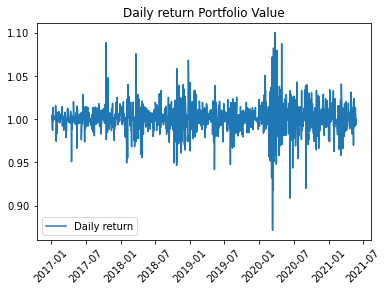

In [14]:
# A chart of daily return ratio over time
plt.plot(data.index,daily_r,label='Daily return')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.title('Daily return Portfolio Value')

In [15]:
daily_r = pd.DataFrame(daily_r,index = data.index,columns=['daily return'])
# print(daily_r)
mean_daily = daily_r['daily return'].mean()
print("Average daily rate of return:",mean_daily)
mean_return_annualized = mean_daily**252 - 1
print("Annualized mean return ：", mean_return_annualized)

Average daily rate of return: 1.0008629438506191
Annualized mean return ： 0.2428014628763293


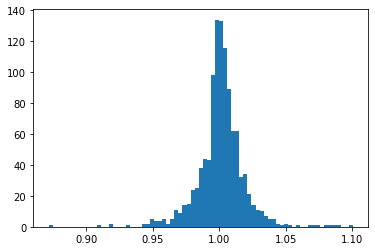

In [16]:
# A histogram of returns
plt.hist(np.array(daily_r), bins=75)
plt.show()

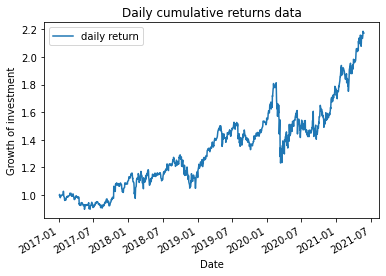

In [17]:
# This chart shows the cumulative returns since 2015 for four datasets.
cum_returns = daily_r.cumprod()
cum_returns.plot()
plt.xlabel("Date")
plt.ylabel("Growth of investment")
plt.title("Daily cumulative returns data")
plt.show()

In [18]:
std_daily = np.std(np.array(daily_r))
print("Daily rate return standard deviation: ", std_daily)
variance_daily = std_daily ** 2
print("Daily rate return variance: ", variance_daily)
std_annualized = std_daily*np.sqrt(252)
print("Annualized standard deviation：", std_annualized)
variance_annualized = std_annualized ** 2
print("Annualized variance：", variance_annualized)

Daily rate return standard deviation:  0.0179207742388759
Daily rate return variance:  0.00032115414932075805
Annualized standard deviation： 0.2844834716267907
Annualized variance： 0.08093084562883104


In [19]:
volatility = std_daily * np.sqrt(252)
print("Volatility is: ",volatility)
SR = mean_daily/std_daily
print("Daily Sharpe ratio is: ",SR)
ASR=np.sqrt(252)*SR
print("Annualized Sharpe ratio is: ",ASR)

Volatility is:  0.2844834716267907
Daily Sharpe ratio is:  55.849313791333124
Annualized Sharpe ratio is:  886.580371112864


In [20]:
# Max Drawdown
maximum = np.maximum.accumulate(np.array(daily_r))
MDD = ((maximum - np.array(daily_r)) / maximum).max()
print("Max Drawdown is: ",MDD)
CS = mean_return_annualized/MDD
print("Calmar Ratio is: ",CS)
win_rate = np.sum(np.array(daily_r)>=1) / np.array(daily_r).size
print("Winning days rate: ",win_rate)


Max Drawdown is:  0.19947014936331176
Calmar Ratio is:  1.2172320703189257
Winning days rate:  0.5475113122171946


In [43]:
ph=np.arange(-0.5,0.5,0.05)
# epsilon=np.arange(-4,0,0.2)
# phi=0.95 # Confidence parameter for profitable mean reversion portfolio.Recommended value is 0.95.
eps=-0.5 # Mean reversion threshold (expected return on current day must be lower than this threshold). Recommended value is -0.5.
# INITIALIZE:
cum_ret=np.ones(20) # Initialization
bah=np.ones(20) # Initialization
bcrp=np.ones(20) # Initialization

lambd = 0
mu = np.ones(d)/d # mu: last portfolio mean
sigma = np.eye(d)/(d**2) # sigma: last diagonal covariance matrix
weight=mu/np.sum(mu)
theta = scipy.stats.norm.ppf(phi) # Quantile function (inverse of CDF
daily_r=np.ones(N)

for r in range(20):
    phi = ph[r]
    for t in range(N-1):
        # 4. Calculate the following variables    
        M = np.dot(mu.T,x[t])
        V = np.dot(np.dot(x[t].T, sigma),x[t])
        W = np.dot(np.dot(x[t].T, sigma),np.ones(d))
        x_bar = (np.dot(np.ones(d),np.dot(sigma,x[t]))/np.dot((np.dot(np.ones(d),sigma)),np.ones(d)))
        # 5. Update mu and sigma
    #     mu, sigma = CWMR_Var(x[t], x_bar, mu, sigma, M, V, theta, eps)
        mu, sigma = CWMR_Stdev(x[t], x_bar, mu, sigma, M, V, theta, eps)
        # 6. Normalize mu and sigma    
        mu = simplex_proj(mu)
        sigma = sigma / (d**2 * trace(sigma))
        weight = mu
    #     tc = gamma/2 * (np.abs(((x[t+1]*weight)/ (np.dot(x[t+1],weight)))[1:] - weight[1:])).sum()
        daily_r[t] = np.dot(x[t+1],weight) #* (1-tc)
        cum_ret[r] = cum_ret[r] * daily_r[t] 
        bah[r] = BAH
        bcrp[r] = BCRP

#     print("Cumulative return:",cum_ret[r]) 
print("Cumulative return wwww:",cum_ret) 
print("Cumulative return bah:",bah) 
print("Cumulative return bcrp:",bah) 

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt


Cumulative return wwww: [2.17102704 2.17102473 2.17102183 2.1710181  2.17101312 2.17100616
 2.1709957  2.17097826 2.17094332 2.17083802 3.24512439 2.17118382
 2.17115176 2.17111722 2.17109992 2.17108953 2.1710826  2.17107765
 2.17107393 2.17107104]
Cumulative return bah: [3.26472694 3.26472694 3.26472694 3.26472694 3.26472694 3.26472694
 3.26472694 3.26472694 3.26472694 3.26472694 3.26472694 3.26472694
 3.26472694 3.26472694 3.26472694 3.26472694 3.26472694 3.26472694
 3.26472694 3.26472694]
Cumulative return bcrp: [3.26472694 3.26472694 3.26472694 3.26472694 3.26472694 3.26472694
 3.26472694 3.26472694 3.26472694 3.26472694 3.26472694 3.26472694
 3.26472694 3.26472694 3.26472694 3.26472694 3.26472694 3.26472694
 3.26472694 3.26472694]


Text(0.5, 1.0, 'Daily return value with different Phi size')

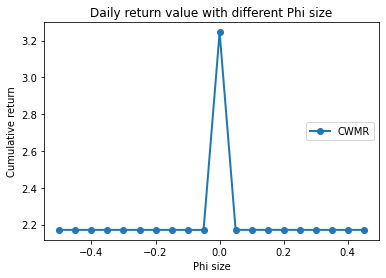

In [44]:
# A chart of daily return ratio over Phi
plt.plot(ph,cum_ret,label='CWMR',linewidth=2,marker='o',markersize=6)
# plt.plot(ph,bah,label='Market',linewidth=2,marker='*',markersize=6)
# plt.plot(ph,bcrp,label='BCRP',linewidth=2,marker='+',markersize=6)
# plt.xticks(rotation=45)
# plt.xticks(np.arange(-10,10,1))
plt.xlabel('Phi size')
plt.ylabel('Cumulative return')
plt.legend(loc=5)
plt.title('Daily return value with different Phi size')


In [45]:
# ph=np.arange(-0.5,0.5,0.05)
epsilon=np.arange(-4,0,0.2)
phi=0.95 # Confidence parameter for profitable mean reversion portfolio.Recommended value is 0.95.
# eps=-0.5 # Mean reversion threshold (expected return on current day must be lower than this threshold). Recommended value is -0.5.
# INITIALIZE:
cum_ret=np.ones(20) # Initialization

lambd = 0
mu = np.ones(d)/d # mu: last portfolio mean
sigma = np.eye(d)/(d**2) # sigma: last diagonal covariance matrix
weight=mu/np.sum(mu)
theta = scipy.stats.norm.ppf(phi) # Quantile function (inverse of CDF
daily_r=np.ones(N)

for r in range(20):
    eps = epsilon[r]
    for t in range(N-1):
        # 4. Calculate the following variables    
        M = np.dot(mu.T,x[t])
        V = np.dot(np.dot(x[t].T, sigma),x[t])
        W = np.dot(np.dot(x[t].T, sigma),np.ones(d))
        x_bar = (np.dot(np.ones(d),np.dot(sigma,x[t]))/np.dot((np.dot(np.ones(d),sigma)),np.ones(d)))
        # 5. Update mu and sigma
    #     mu, sigma = CWMR_Var(x[t], x_bar, mu, sigma, M, V, theta, eps)
        mu, sigma = CWMR_Stdev(x[t], x_bar, mu, sigma, M, V, theta, eps)
        # 6. Normalize mu and sigma    
        mu = simplex_proj(mu)
        sigma = sigma / (d**2 * trace(sigma))
        weight = mu
    #     tc = gamma/2 * (np.abs(((x[t+1]*weight)/ (np.dot(x[t+1],weight)))[1:] - weight[1:])).sum()
        daily_r[t] = np.dot(x[t+1],weight) #* (1-tc)
        cum_ret[r] = cum_ret[r] * daily_r[t] 
#     print("Cumulative return:",cum_ret[r]) 
print("Cumulative return epsilon:",cum_ret) 


Cumulative return epsilon: [2.08882276 2.08852873 2.08823467 2.0888471  2.09125614 2.09297312
 2.09468899 2.09959818 2.10777677 2.11524604 2.12196098 2.12764147
 2.1362161  2.1452606  2.15413613 2.16305157 2.16733098 2.16951049
 2.17604666 2.18721384]


Text(0.5, 1.0, 'Daily return value with different Epsilon size')

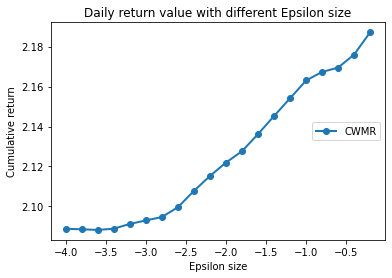

In [46]:
# A chart of daily return ratio over epsilon
plt.plot(epsilon,cum_ret,label='CWMR',linewidth=2,marker='o',markersize=6)
# plt.xticks(rotation=45)
# plt.xticks(np.arange(-4,0,0.2))
plt.xlabel('Epsilon size')
plt.ylabel('Cumulative return')
plt.legend(loc=5)
plt.title('Daily return value with different Epsilon size')